In [1]:
import ModelManager as mm_mod
import config_defaults as cd
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
import torch

from tqdm import tqdm_notebook as tqdm


%matplotlib inline
%load_ext autotime

### Initializing the Model and Data pipes

In [2]:
reload(mm_mod)
reload(cd)
logger = logging.getLogger('__main__')
logger.setLevel(logging.INFO)

time: 1.16 ms


## extracting the ngrams for n = 1, 2, 3, 4 with both naive and spacy

In [ ]:
"""
n_list = (1, 2, 3, 4)
mode_list = ('naive', 'spacy')

for n in n_list:
    for mode in mode_list:
        print("extracting n-grams for: n=%s, mode=%s" % (n, mode))
        param_overrides = {'NGRAM_MODE': mode,
                           'NGRAM_SIZE': n}
        mm = mm_mod.ModelManager(hparams=param_overrides)
        mm.load_data()
"""

### Testing the annealing of LR

In [ ]:
# training all of these through 1 epoch and seeing results
reload(mm_mod)
mm = mm_mod.ModelManager()
mm.load_data()
mm.data_to_pipe()
param_overrides = {'EARLY_STOP': False}
mm.hparams.update(param_overrides)
mm.train(epoch_override=3, reload_data=False)  

### Trying to find a good LR

In [ ]:
lr_list_exp_neg = np.arange(1,6)
lr_list_neg = 1 / np.power(10, lr_list_exp_neg)
lr_list_exp_pos = np.arange(0,3)
lr_list_pos = np.power(10, lr_list_exp_pos)

lr_list = np.append(lr_list_neg, lr_list_pos)
lr_list.sort()
print(lr_list)

In [ ]:
# training all of these through 1 epoch and seeing results
mm = mm_mod.ModelManager()
mm.load_data()
mm.data_to_pipe()

mm.res_df = None  # reset the results dataframe
for cur_lr in lr_list:
    # overriding some hyperparameters
    print("training for initial lr = %s" % cur_lr)
    param_overrides = {'LR': cur_lr,
                       'EARLY_STOP': False}
    mm.hparams.update(param_overrides)
    mm.train(epoch_override=1, reload_data=False)  
display(mm.res_df)

In [ ]:
plt.scatter(np.log10(mm.res_df['LR']), mm.res_df['final_val_acc'])
plt.title('Validation Error after 1 epoch')
plt.show()

In [ ]:
mm.save_results()

### for each ngram param, find the right vocabulary size:

In [ ]:
reload(mm_mod)
logger.setLevel(logging.WARNING)
voc_sizes = np.arange(1, 9) * 10000
n_list = (1, 2, 3, 4)
mode_list = ('naive', 'spacy')

for n in n_list:
    for mode in mode_list:
        for voc_size in voc_sizes:
            start_time = time.time()
            print("training models for: n=%s, mode=%s, voc_size=%s" % (n, mode, voc_size))
            param_overrides = {'NGRAM_MODE': mode,
                               'NGRAM_SIZE': n,
                               'VOC_SIZE': voc_size}
            mm = mm_mod.ModelManager(hparams=param_overrides, res_name='vocab_explore.p')
            mm.train()
            print("Final Validation Acc = %s (train time: %.1fs)\n" % (mm.validation_acc_history[-1], 
                                                                  time.time() - start_time))
    
            mm.save_results()

### Extra vocabulary - for spacy ngram =4, the upper tail hasn't been fully explored

In [ ]:
voc_sizes = np.arange(9, 15) * 10000
for voc_size in voc_sizes:
    start_time = time.time()
    print("training models for: n=4, mode=spacy, voc_size=%s" % (voc_size))
    param_overrides = {'NGRAM_MODE': 'spacy',
                       'NGRAM_SIZE': 4,
                       'VOC_SIZE': voc_size}
    mm = mm_mod.ModelManager(hparams=param_overrides, res_name='voc_additional.p')
    mm.train()
    print("Final Validation Acc = %s (train time: %.1fs)\n" % (mm.validation_acc_history[-1], 
                                                          time.time() - start_time))

    mm.save_results()

In [ ]:
voc_sizes = np.arange(3, 11) * 100000
voc_sizes

### What if we tried even larger vocabsizes?

In [ ]:
voc_sizes = np.arange(3, 11) * 100000
for voc_size in voc_sizes:
    start_time = time.time()
    print("training models for: n=4, mode=spacy, voc_size=%s" % (voc_size))
    param_overrides = {'NGRAM_MODE': 'spacy',
                       'NGRAM_SIZE': 4,
                       'VOC_SIZE': voc_size}
    mm = mm_mod.ModelManager(hparams=param_overrides, res_name='voc_additional.p')
    mm.train()
    print("Final Validation Acc = %s (train time: %.1fs)\n" % (mm.validation_acc_history[-1], 
                                                          time.time() - start_time))

    mm.save_results()

### Embedding size

In [ ]:
emb_dims = np.arange(2, 15) * 50
emb_dims

In [ ]:
reload(mm_mod)
logger.setLevel(logging.WARNING)
voc_sizes = np.arange(2, 13) * 10000
emb_dims = np.arange(1, 15) * 50

for emb_dim in emb_dims:
    for voc_size in voc_sizes:
        start_time = time.time()
        print("training models for: emb_dim=%s, voc_size=%s" % (emb_dim, voc_size))
        param_overrides = {'VOC_SIZE': voc_size,
                           'NGRAM_MODE':'spacy',
                           'EMBEDDING_DIM':emb_dim}
        mm = mm_mod.ModelManager(hparams=param_overrides, res_name='embdim.p')
        mm.train()
        print("Final Validation Acc = %s (train time: %.1fs)\n" % (mm.validation_acc_history[-1], 
                                                              time.time() - start_time))

        mm.save_results()

In [ ]:
plt.plot(mm.res_df['final_val_acc'].sort_values().values)
plt.show()

In [ ]:
df = mm.res_df

In [ ]:
import torch

In [ ]:
opt_list = [torch.optim.RMSprop, torch.optim.Adagrad, torch.optim.Adam, torch.optim.SGD]
first_loop = True

for opt in opt_list:
    start_time = time.time()
    print("training models for: optimizer = %s" % (str(opt)))
    param_overrides = {'OPTIMIZER': opt}
    mm = mm_mod.ModelManager(hparams=param_overrides, res_name='optim.p')
    mm.train(epoch_override=2)
    print("Final Validation Acc = %s (train time: %.1fs)\n" % (mm.val_acc_hist[-1], 
                                                          time.time() - start_time))

    mm.save_results()
    first_loop = False

### Trying different LR decay rates

In [ ]:
lr_decays = 0.5 + np.arange(2, 11) * 0.05

for lr_decay in lr_decays:
    param_overrides = {'LR_DECAY_RATE': lr_decay,
                       'LR': 0.001,
                       'NEPOCH': 30}
    mm = mm_mod.ModelManager(hparams=param_overrides, res_name='lr_decay_small_lr.p')
    mm.train()
    mm.save_results()

print("Final Validation Acc = %s" % (mm.validation_acc_history[-1]))

### The final massive model

In [ ]:
reload(mm_mod)
logger.setLevel(logging.INFO)
start_time = time.time()
param_overrides = {'NEPOCH': 50,
                   'LR': 0.001,
                   'LR_DECAY_RATE': 0.95,
                   'VOC_SIZE': 2000000,
                   'NGRAM_SIZE': 4,
                   'NGRAM_MODE':'spacy',
                   'EMBEDDING_DIM':100,
                   'EARLY_STOP_LOOKBACK': 16}
mm = mm_mod.ModelManager(hparams=param_overrides, res_name='experiment.p')
mm.train()
print("Final Validation Acc = %s (train time: %.1fs)\n" % (mm.val_acc_hist[-1], 
                                                      time.time() - start_time))

In [4]:
mm.test_model()

CRITICAL !!!! THIS IS THE FINAL TEST RESULT, DO NOT FURTHER OPTIMIZE !!!!


(90.084, 322.83760064840317)

time: 3.11 s


In [ ]:
torch.save(mm.model, r'model_state.st')

### Training Curves

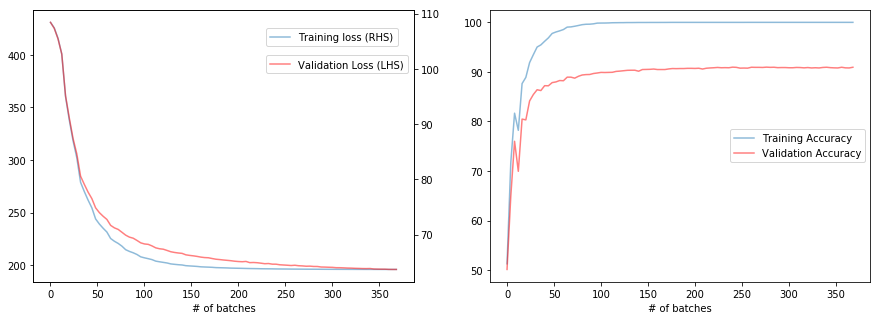

time: 166 ms


In [6]:
batch_counter = np.arange(0,len(mm.train_loss_hist))*4


f, axs = plt.subplots(1, 2, figsize=(15,5))
ax1 = axs[0]
ax1.plot(batch_counter, mm.train_loss_hist, alpha = 0.5, label='Training loss (RHS)')
ax1.set_xlabel("# of batches")
ax1.legend(loc='center left', bbox_to_anchor=(0.6, 0.9))
ax2 = ax1.twinx()
ax2.plot(batch_counter, mm.val_loss_hist, color='r', alpha=0.5, label='Validation Loss (LHS)')
ax2.legend(loc='center left', bbox_to_anchor=(0.6, 0.8))

ax3 = axs[1]
ax3.plot(batch_counter, mm.train_acc_hist, alpha = 0.5, label='Training Accuracy')
ax3.set_xlabel("# of batches")
ax3.plot(batch_counter, mm.val_acc_hist, color='r', alpha=0.5, label='Validation Accuracy')
ax3.legend(loc='center right')
plt.show()

In [7]:
mm.test_model()

CRITICAL !!!! THIS IS THE FINAL TEST RESULT, DO NOT FURTHER OPTIMIZE !!!!


(90.084, 322.83760064840317)

time: 3.07 s


### Pulling out examples

In [23]:
import data_processor as dp
from torch.utils.data import DataLoader
import torch.nn.functional as F

time: 520 µs


In [55]:
correctly_predicted = []
incorrectly_predicted = []

correct = 0
imdb_val = dp.IMDBDataset(mm.data['val'])

cur_loader = DataLoader(dataset=imdb_val,
                        batch_size=1,
                        collate_fn=dp.imdb_collate_func,
                        shuffle=False)
    
for i, (data, lengths, labels) in enumerate(cur_loader):
    outputs = F.softmax(mm.model(data, lengths), dim=1)
    # print(outputs)

    predicted = outputs.max(1, keepdim=True)[1]
    # print(predicted, labels)
    is_correct = predicted.eq(labels.view_as(predicted)).sum().item()
    correct += is_correct
    
    if is_correct == 1:
        correctly_predicted.append(mm.data['val'][i])
    else:
        incorrectly_predicted.append(mm.data['val'][i])

time: 2.04 s


In [56]:
print("correct predictions:")
for i in range(0,3):
    print(correctly_predicted[i].file_name)
    
print("\nincorrect predictions:")
for i in range(0,3):
    print(incorrectly_predicted[i].file_name)

correct predictions:
./data/aclImdb/train/pos/2871_10.txt
./data/aclImdb/train/neg/10085_3.txt
./data/aclImdb/train/pos/10366_10.txt

incorrect predictions:
./data/aclImdb/train/neg/2304_1.txt
./data/aclImdb/train/neg/3772_2.txt
./data/aclImdb/train/neg/7120_4.txt
time: 972 µs


In [57]:
print("correct predictions:")
for i in range(0,3):
    print(correctly_predicted[i].raw_text)
    print()
    
print("\nincorrect predictions:")
for i in range(0,3):
    print(incorrectly_predicted[i].raw_text)
    print()

correct predictions:
comment? like my comment is necessary? we are talking about all time masterpiece, for all seasons and all generations. this is only type of movies that i still have patience to watch. in this, like in other disney's movies is some kind of magic. all characters are in some way, "alive" and "real" so it's easy to understand message, even if you don't understand language, (like i didn't understood when i first watched movie, because i was about six years old). maybe my english is not so good, but i learned what i know mostly from this kind of movies, and this is one more great dimension of this kind of movies, which in present time are rare. but there is a one big shame. in my country is now impossible to watch this, or any other disney's movie! we don't have copyrights, so our children are disabled to enjoy and learn from this kind of movies. so, we will watch this movie again "once upon a dream" or...?

why do all movies on lifetime have such anemic titles? "an unex

### Loading the model from state

In [ ]:
loaded_model = torch.load(r'model_state.st')

param_overrides = {'NEPOCH': 50,
                   'LR': 0.001,
                   'LR_DECAY_RATE': 0.95,
                   'VOC_SIZE': 1000000,
                   'NGRAM_SIZE': 4,
                   'NGRAM_MODE':'spacy',
                   'EMBEDDING_DIM':100,
                   'EARLY_STOP_LOOKBACK': 32}
mm_test = mm_mod.ModelManager(hparams=param_overrides)
mm_test.load_data()
mm_test.data_to_pipe()
mm_test.model = loaded_model

mm_test.test_model(mm_test.loaders['test'])[0]

### recreating archives

In [ ]:
import config_defaults as cd
import data_processor as dp
import ngrams
import pickle as pkl

In [ ]:
mm = mm_mod.ModelManager()

In [ ]:
test_set = dp.construct_dataset(cd.DIR_TEST, cd.TEST_SIZE)

In [ ]:
test_data = ngrams.extract_ngrams(test_set,
                                  mm.hparams['NGRAM_SIZE'],
                                  remove_stopwords=mm.hparams['REMOVE_STOP_WORDS'],
                                  remove_punc=mm.hparams['REMOVE_PUNC'],
                                  mode=mm.hparams['NGRAM_MODE'])

In [ ]:
def hparam_to_str(hparams, req_params):
    final_str = ''
    for key in sorted(hparams):
        if key in req_params:
            final_str += str(hparams[key]).replace('.', 'p').replace(':', '-') + "_"
    return final_str[:-1] + '.p'

pickle_path_test = cd.DIR_PICKLE + 'test_' + hparam_to_str(mm.hparams, cd.DATA_HPARAMS)
pkl.dump(test_data, open(pickle_path_test, "wb"))

### Curves 